In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/amex-default-prediction/sample_submission.csv
/kaggle/input/amex-default-prediction/train_data.csv
/kaggle/input/amex-default-prediction/test_data.csv
/kaggle/input/amex-default-prediction/train_labels.csv
/kaggle/input/amex-parquet/test_data.parquet
/kaggle/input/amex-parquet/train_data.parquet


Our goal is to use this industrial scale dataset to predict the probability that a customer will default in the future. Eighteen months of profile data is stored for each customer previous their most recent credit card statement. If they do not pay this amount within 120 days of the statement it is considered a default.




# Exploratory Data Analysis

The data was converted from .csv to .parquet to enable quick loading into pandas within our 16gb RAM environment. 

<br />Now we preview the data.

In [2]:
import pandas as pd

df=pd.read_parquet('/kaggle/input/amex-parquet/train_data.parquet')
print(df.shape)
#df.head()

(5531451, 191)


Wow! We have over 5.5 million rows and 190 columns. Our column names are anonymized but fall into these categories: 
 <br />D_* = Delinquency variables
 <br />S_* = Spend variables
 <br />P_* = Payment variables
 <br />B_* = Balance variables
 <br />R_* = Risk variables
 <br />
 <br />
The size of the data is too large for our hardware. Let's remove the data we percieve to be less relevant. 

We note the customer ID and the date columns. 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5531451 entries, 0 to 5531450
Columns: 191 entries, customer_ID to target
dtypes: float32(185), int64(2), object(4)
memory usage: 4.1+ GB


There are four non-numeric data types. Let's convert these so we may apply a logistic regression model.

Let's plot our columns.

In [4]:
"""hist = df.hist(bins=50, figsize = (40,200), layout=(-1,4) )"""

'hist = df.hist(bins=50, figsize = (40,200), layout=(-1,4) )'

# **Data Cleaning**

Let's find and remove the columns with a significant amount of NaN values. Without knowledge on the contents of each column we will remove the columns that are likely less useful.

In [5]:
temp = [column for column in df.columns if df[column].isnull().sum()/len(df) >= 0.9]
df.drop(temp, axis=1, inplace=True)

print(df.shape)

(5531451, 173)


Great! We got rid of 18 columns that contained >90% null values. 

We choose to impute by filling customer data from other months.

In [6]:
"""df=df.set_index(['customer_ID'])
df.head(n=20)
#forward fill and back fill just putting random other customers data into their adjacent rows?"""

"df=df.set_index(['customer_ID'])\ndf.head(n=20)\n#forward fill and back fill just putting random other customers data into their adjacent rows?"

In [7]:
pd.set_option('min_rows', 60)
print(df[['customer_ID','D_142']])

                                               customer_ID     D_142
0        0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...       NaN
1        0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...       NaN
2        0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...       NaN
3        0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...       NaN
4        0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...       NaN
5        0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...       NaN
6        0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...       NaN
7        0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...       NaN
8        0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...       NaN
9        0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...       NaN
10       0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...       NaN
11       0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...       NaN
12       0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...       NaN
13       00000fd6641609c6ece545466

In [8]:
temp = df.shape
df=df.set_index(['customer_ID'])
#df=df.ffill()
#df=df.bfill()
df=df.reset_index()

df=df.groupby('customer_ID').tail(1)
df=df.set_index(['customer_ID'])

#Drop date column since it
df.drop(['S_2'],axis=1,inplace=True)

print(temp, df.shape)


temp = [column for column in df.columns if df[column].isnull().sum()/len(df) >0]
print(len(temp))

(5531451, 173) (458913, 171)
91


In [9]:
#df=df.reset_index()
#print(df[['customer_ID','D_142']])

This magically removes all missing data... ??

Lets separate our labels from our dataset.

In [10]:
#print(df[['customer_ID','D_142']])

In [11]:
df_label = df.iloc[:,len(df.columns)-1]
df = df.iloc[:,0:len(df.columns)-1]

print(df_label.sum()/len(df_label))

0.2589336105100531


Our train data contains ~25% positive cases but the negative class was subsampled at 5%

We aim to remove data columns that have too high a correlation.

In [12]:
# Create correlation matrix
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
import numpy as np
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find and drop columns with high correl
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
df.drop(to_drop, axis=1, inplace=True)

print(len(to_drop),df.shape)

15 (458913, 155)


##### To further reduce the degrees of freedom we remove columns with low variance

In [13]:
from sklearn.feature_selection import VarianceThreshold
from itertools import compress

temp = df.drop(['D_63', 'D_64'], axis=1)

# Initialize and fit the method
vt = VarianceThreshold(threshold = float(0.1))
vt.fit(temp)

#columns with sufficient variance
keep = list(compress(temp.columns, vt.get_support()))

#dropped = ['D_63', 'D_64', 'customer_ID', 'S_2']

keep.extend(['D_63', 'D_64',])

#keep = keep + dropped
#keep.append('D_64')
df=df[keep]
keep.extend([ 'customer_ID', 'S_2'])
#keep.append('customer_ID')
#keep.append('S_2')
len(keep)

58

Now lets take a look at our data types.

In [14]:
print(df.dtypes.value_counts())
print(df.columns)
#how to find categorical data encoded as numeric

float32    54
object      2
dtype: int64
Index(['D_39', 'B_2', 'B_5', 'D_48', 'B_6', 'B_8', 'D_50', 'B_10', 'S_5',
       'S_6', 'B_12', 'R_5', 'D_60', 'D_61', 'D_65', 'B_16', 'B_17', 'B_18',
       'B_20', 'D_68', 'R_6', 'B_21', 'D_69', 'D_71', 'P_4', 'B_24', 'R_7',
       'B_26', 'D_78', 'R_8', 'S_16', 'R_10', 'D_81', 'R_14', 'D_84', 'B_30',
       'R_20', 'S_22', 'S_23', 'S_26', 'D_103', 'R_27', 'B_38', 'D_112',
       'B_40', 'S_27', 'D_114', 'D_117', 'D_120', 'D_126', 'D_128', 'D_129',
       'D_130', 'D_139', 'D_63', 'D_64'],
      dtype='object')


Convert our object columns to numeric via one hot encoding

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 458913 entries, 0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a to fffff1d38b785cef84adeace64f8f83db3a0c31e8d92eaba8b115f71cab04681
Data columns (total 56 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   D_39    458913 non-null  float32
 1   B_2     458882 non-null  float32
 2   B_5     458913 non-null  float32
 3   D_48    400921 non-null  float32
 4   B_6     458873 non-null  float32
 5   B_8     454822 non-null  float32
 6   D_50    196678 non-null  float32
 7   B_10    458913 non-null  float32
 8   S_5     458913 non-null  float32
 9   S_6     458913 non-null  float32
 10  B_12    458913 non-null  float32
 11  R_5     458913 non-null  float32
 12  D_60    458913 non-null  float32
 13  D_61    410565 non-null  float32
 14  D_65    458913 non-null  float32
 15  B_16    458882 non-null  float32
 16  B_17    214442 non-null  float32
 17  B_18    458913 non-null  float32
 18  B_20    

In [16]:
df = pd.get_dummies(df)
#print(df['D_64_-1'].sum())
#df.drop(['D_64_-1'], axis=1, inplace = True)
print(df.shape)

(458913, 63)


In [17]:
#Handling missing values
from sklearn.impute import SimpleImputer
my_imputer = SimpleImputer()
df.iloc[:,:] = my_imputer.fit_transform(df.iloc[:,:])

We scale our data for better results

Reshaping data for model training

In [18]:
from sklearn.model_selection import train_test_split


#this okay?
#df=df.reset_index()


x = df.iloc[:, :]
y = df_label.iloc[:]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=23)

In [19]:
"""#does this actually help log regr sig?
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)"""

'#does this actually help log regr sig?\nfrom sklearn import preprocessing\n\nscaler = preprocessing.StandardScaler().fit(X)\nX_scaled = scaler.transform(X)'

# Model Building

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score  
from sklearn.metrics import precision_score                         
from sklearn.metrics import recall_score
# create object for the class
log = LogisticRegression(random_state=12)
log.fit(x_train, y_train) 
y_pred = log.predict(x_test)

print(np.sum(y_pred))
print(log.score(x_test, y_test))
print('\nLogistics Regression Accuracy: {:.3f}'.format(accuracy_score(y_test, y_pred)))


print('\nLogistics Regression Precision: {:.3f}'.format(precision_score (y_test, y_pred)))


print('\nLogistics Regression Recall: {:.3f}'.format(recall_score (y_test, y_pred)))


27211
0.8788449302268825

Logistics Regression Accuracy: 0.879

Logistics Regression Precision: 0.791

Logistics Regression Recall: 0.724


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


# Results

Accuracy: 0.879
0.8284572508888731


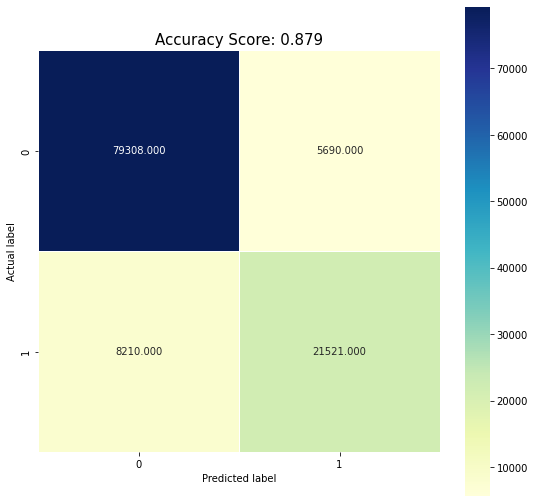

In [21]:
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

cm = metrics.confusion_matrix(y_test, y_pred)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'YlGnBu');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');

score = log.score(x_test, y_test)

all_sample_title = 'Accuracy Score: {0}'.format(round(score,3))

#all_sample_title = 'Accuracy Score: {0}'.format(round(log.score(x_test, y_test),3))
plt.title(all_sample_title, size = 15);

print('Accuracy:',round(metrics.accuracy_score(y_test, y_pred),3))
metrics.roc_curve(y_test, y_pred)
print(metrics.roc_auc_score(y_test, y_pred))

In [22]:
"""
#trying random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
# Number of trees in random forest
n_estimators = [int(i) for i in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(i) for i in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

model = RandomForestClassifier(n_estimators=400, max_features='sqrt', bootstrap=True, max_depth=30, min_samples_leaf=1, min_samples_split=5, n_jobs=-1)


#rf_random = GridSearchCV(estimator = rf, param_grid = random_grid, cv = 3, verbose=1, n_jobs = -1)
# Fit the random search model


model.fit(x_train,y_train)"""

"\n#trying random forest\nfrom sklearn.ensemble import RandomForestClassifier\nfrom sklearn.model_selection import RandomizedSearchCV, GridSearchCV\n# Number of trees in random forest\nn_estimators = [int(i) for i in np.linspace(start = 200, stop = 2000, num = 10)]\n# Number of features to consider at every split\nmax_features = ['auto', 'sqrt']\n# Maximum number of levels in tree\nmax_depth = [int(i) for i in np.linspace(10, 110, num = 11)]\nmax_depth.append(None)\n# Minimum number of samples required to split a node\nmin_samples_split = [2, 5, 10]\n# Minimum number of samples required at each leaf node\nmin_samples_leaf = [1, 2, 4]\n# Method of selecting samples for training each tree\nbootstrap = [True, False]\n# Create the random grid\nrandom_grid = {'n_estimators': n_estimators,\n               'max_features': max_features,\n               'max_depth': max_depth,\n               'min_samples_split': min_samples_split,\n               'min_samples_leaf': min_samples_leaf,\n        

In [23]:
"""y_pred = model.predict_proba(x_test)
#y_pred = model.predict(x_test)
#y_pred = y_pred[:,1]
print(y_pred.shape, y_pred[25:50])"""

'y_pred = model.predict_proba(x_test)\n#y_pred = model.predict(x_test)\n#y_pred = y_pred[:,1]\nprint(y_pred.shape, y_pred[25:50])'

In [24]:
"""print(y_test, y_test.shape)"""

'print(y_test, y_test.shape)'

In [25]:
"""from sklearn.ensemble import RandomForestClassifier

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    print(predictions, test_labels)
    errors = abs(predictions - test_labels)
    print(errors)
    mape = 100 * np.mean(errors / test_labels)
    print('mape',mape)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy
base_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
base_model.fit(x_train, y_train)
base_accuracy = evaluate(base_model, x_test, y_test)"""

"from sklearn.ensemble import RandomForestClassifier\n\ndef evaluate(model, test_features, test_labels):\n    predictions = model.predict(test_features)\n    print(predictions, test_labels)\n    errors = abs(predictions - test_labels)\n    print(errors)\n    mape = 100 * np.mean(errors / test_labels)\n    print('mape',mape)\n    accuracy = 100 - mape\n    print('Model Performance')\n    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))\n    print('Accuracy = {:0.2f}%.'.format(accuracy))\n    \n    return accuracy\nbase_model = RandomForestClassifier(n_estimators = 10, random_state = 42)\nbase_model.fit(x_train, y_train)\nbase_accuracy = evaluate(base_model, x_test, y_test)"

In [26]:
import gc
#free up ram
del df
gc.collect()

5066

In [27]:
print(len(keep), keep)

58 ['D_39', 'B_2', 'B_5', 'D_48', 'B_6', 'B_8', 'D_50', 'B_10', 'S_5', 'S_6', 'B_12', 'R_5', 'D_60', 'D_61', 'D_65', 'B_16', 'B_17', 'B_18', 'B_20', 'D_68', 'R_6', 'B_21', 'D_69', 'D_71', 'P_4', 'B_24', 'R_7', 'B_26', 'D_78', 'R_8', 'S_16', 'R_10', 'D_81', 'R_14', 'D_84', 'B_30', 'R_20', 'S_22', 'S_23', 'S_26', 'D_103', 'R_27', 'B_38', 'D_112', 'B_40', 'S_27', 'D_114', 'D_117', 'D_120', 'D_126', 'D_128', 'D_129', 'D_130', 'D_139', 'D_63', 'D_64', 'customer_ID', 'S_2']


In [28]:
#run prediction on test dat
#only loading columns that model utilizes
df2=pd.read_parquet('/kaggle/input/amex-parquet/test_data.parquet', columns =keep)
print(df2.shape)

(11363762, 58)


In [29]:
#Handling missing values via imputation
#df2.iloc[:,:] = my_imputer.fit_transform(df2.iloc[:,:])

In [30]:
#using only most recent transaction from each customer
#Does this make sense for test data??
temp = df2.shape
df2=df2.set_index(['customer_ID'])
#df2=df2.ffill()
#df2=df2.bfill()
df2=df2.reset_index()

df2=df2.groupby('customer_ID').tail(1)
df2=df2.set_index(['customer_ID'])

#Drop date column since it is no longer useful
df2.drop(['S_2'],axis=1,inplace=True)

print(temp, df2.shape)

#inspecting NaN
print('Columns left with NaN:')
for i in range(len(df2.columns)):
    if (df2.iloc[:,i].isnull().sum()/len(df2) > 0):
        print(df2.columns[i], round(df2.iloc[:,i].isnull().sum()/len(df2),2))

(11363762, 58) (924621, 56)
Columns left with NaN:
B_2 0.0
D_48 0.13
B_6 0.0
B_8 0.01
D_50 0.57
D_61 0.11
B_16 0.0
B_17 0.52
B_20 0.0
D_68 0.02
D_69 0.02
B_26 0.0
D_78 0.05
D_81 0.0
D_84 0.0
B_30 0.0
S_22 0.01
S_23 0.0
S_26 0.0
D_103 0.01
R_27 0.06
B_38 0.0
D_112 0.0
B_40 0.0
S_27 0.23
D_114 0.02
D_117 0.02
D_120 0.02
D_128 0.01
D_129 0.01
D_130 0.01
D_139 0.01
D_64 0.03


In [31]:
#one hot encoding
df2 = pd.get_dummies(df2)

In [32]:
from sklearn.impute import SimpleImputer
my_imputer = SimpleImputer()
df2.iloc[:,:] = my_imputer.fit_transform(df2.iloc[:,:])

In [33]:
from sklearn import preprocessing

X2 = df2.iloc[:, :].values.reshape(-1, len(df2.columns))
#scaler = preprocessing.StandardScaler().fit(X2)
#X2 = scaler.transform(X2)


Y_pred2 = log.predict_proba(X2)
#necessary for predict_proba, as it outputs prob of all classes
Y_pred2 = Y_pred2[:,1]
print(Y_pred2)

df2 = df2.reset_index()

final = pd.DataFrame({"customer_ID":df2.customer_ID,"prediction":Y_pred2})

print(Y_pred2, np.sum(Y_pred2))

#initial score ended as ~50 w/o scaler

[0.22016944 0.01156095 0.15025838 ... 0.45693484 0.46304212 0.07029843]
[0.22016944 0.01156095 0.15025838 ... 0.45693484 0.46304212 0.07029843] 241990.02721464453


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


In [34]:
"""Y_pred2 = model.predict_proba(df2)
Y_pred2 = Y_pred2[:,1]
df2 = df2.reset_index()
print(Y_pred2, np.sum(Y_pred2))
final = pd.DataFrame({"customer_ID":df2.customer_ID,"prediction":Y_pred2})
print(final)"""

'Y_pred2 = model.predict_proba(df2)\nY_pred2 = Y_pred2[:,1]\ndf2 = df2.reset_index()\nprint(Y_pred2, np.sum(Y_pred2))\nfinal = pd.DataFrame({"customer_ID":df2.customer_ID,"prediction":Y_pred2})\nprint(final)'

In [35]:
final.to_csv('submission.csv', index=False)
print(final)

                                              customer_ID  prediction
0       00000469ba478561f23a92a868bd366de6f6527a684c9a...    0.220169
1       00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...    0.011561
2       0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...    0.150258
3       00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...    0.382377
4       00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...    0.954028
5       00004ffe6e01e1b688170bbd108da8351bc4c316eacfef...    0.007146
6       00007cfcce97abfa0b4fa0647986157281d01d3ab90de9...    0.921407
7       000089cc2a30dad8e6ba39126f9d86df6088c9f975093a...    0.363824
8       00008f50a1dd76fa211ba36a2b0d5a1b201e4134a5fd53...    0.773871
9       0000b48a4f27dc1d61e78d081678e811620300b88eb3ab...    0.007017
10      0000bccc55cf039a23d49832234f224085716d85bed7d2...    0.139724
11      0000c7144ae91777aeeb02a7e02bdbfe7edb127b69fa53...    0.538344
12      0000f63151bd00e2ebad53ff5fb207fed9139a89f50711...    0.060406
13      00010121860f